# necessary packages

In [1]:
import time
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import copy

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
#from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.util import ngrams
from keras import optimizers

In [4]:
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

C:\Users\smita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

# 2. Getting and performing data cleaning

In [5]:
#2.1. load_doc( filename ) – For loading the document file and reading the contents inside the file into a string

In [6]:
# Set these path according to project folder in you system
dataset_text = "C:\\Users\\smita\\Desktop\\Aegis School of Data Science\\Capstone Project Folder\\Flickr8k_text"
dataset_images = "C:\\Users\\smita\\Desktop\\Aegis School of Data Science\\Capstone Project Folder\\Flickr8k_Dataset\\Flicker8k_Dataset"

In [7]:
#we prepare our text data
filename = dataset_text + "\\" + "Flickr8k.token.txt"

In [8]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [9]:
load_doc(filename)

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [10]:
#2.2 all_img_captions( filename ) – This function will create a descriptions dictionary that maps images with a list of 
#5 captions

In [11]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [12]:
file = load_doc(filename)
captions = file.split('\n')

In [13]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [14]:
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [15]:
descriptions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

# Pictures with captions

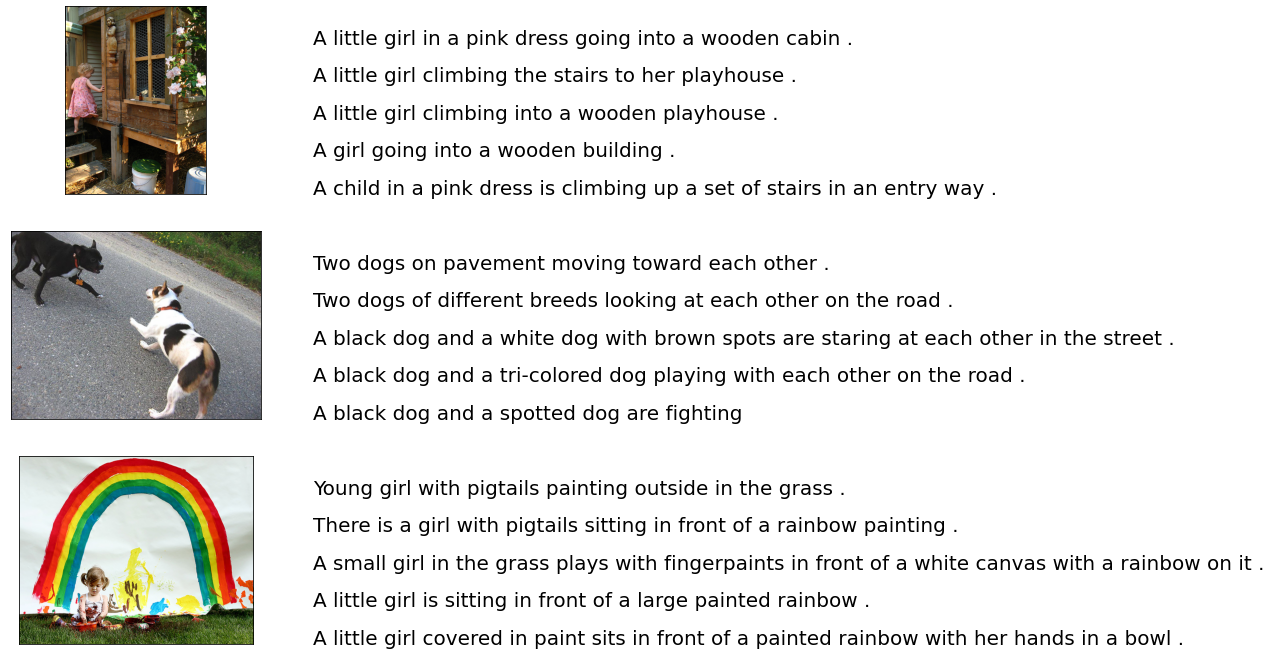

In [16]:
count=1
fig = plt.figure(figsize=(10,20))
for jpg_name in (list(descriptions.keys()))[:3]:
    name = dataset_images + "\\" + jpg_name
    for key in descriptions.keys():
        if key==jpg_name:
            annotation=descriptions[key]
            image_load=load_img(name, (224,224,3))
            
    ax=fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count+=1
    
    ax=fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(annotation))
    for i, annotation in enumerate(annotation):
        ax.text(0,i,annotation,fontsize=20)
    count+=1
plt.show()

In [17]:
#2.3 cleaning_text( descriptions) – This function takes all descriptions and performs data cleaning. 
#This is an important step when we work with textual data, according to our goal, we decide what type of cleaning we 
#want to perform on the text. In our case, we will be removing punctuations, converting all text to lowercase and 
#removing words that contain numbers.

In [18]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img, caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [19]:
clean_descriptions = cleaning_text(descriptions)

In [20]:
clean_descriptions

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young 

# Vocabulary

In [21]:
#2.4 text_vocabulary( descriptions ) – This is a simple function that will separate all the unique words and create 
#the vocabulary from all the descriptions.

In [22]:
#def text_vocabulary(descriptions):
#    # build vocabulary of all unique words
#    vocab = set()
#    for key in descriptions.keys():
#        [vocab.update(d.split()) for d in descriptions[key]]
#    return vocab
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    vocab_list = []
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
        #[vocab_list.extend(d.split()) for d in descriptions[key]]
        [vocab_list.extend(d.split()) for d in descriptions[key]]
    return vocab, vocab_list

In [23]:
vocabulary, vocabulary_list = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
print("Length of vocabulary_list = ", len(vocabulary_list))

Length of vocabulary =  8763
Length of vocabulary_list =  372935


In [24]:
vocabulary

{'dragon',
 'mail',
 'groomed',
 'marketplace',
 'travelling',
 'this',
 'pinata',
 'wide',
 'joyfully',
 'possession',
 'photographer',
 'padded',
 'bluejeans',
 'chipmunk',
 'flares',
 'entwined',
 'layered',
 'arranged',
 'knocking',
 'curve',
 'frisbeen',
 'canned',
 'coffin',
 'anime',
 'frolics',
 'ends',
 'urban',
 'haircut',
 'trumpet',
 'piglet',
 'strap',
 'load',
 'diver',
 'partying',
 'engine',
 'collies',
 'braided',
 'hawaiian',
 'portojohn',
 'alcohol',
 'transportation',
 'swordfighting',
 'bandaged',
 'belted',
 'opposite',
 'trade',
 'rappels',
 'arabic',
 'come',
 'sleeps',
 'newspapers',
 'mark',
 'multiple',
 'seedoo',
 'bigwheels',
 'mastif',
 'dale',
 'african',
 'shoeshine',
 'folks',
 'depth',
 'crucified',
 'dramatically',
 'gettin',
 'tents',
 'crocodile',
 'nursery',
 'working',
 'bag',
 'jack',
 'swords',
 'encourages',
 'spectating',
 'same',
 'footage',
 'peeping',
 'trails',
 'scampers',
 'laying',
 'poll',
 'hulahoops',
 'ref',
 'gestures',
 'buffalo',

In [25]:
ct=Counter(vocabulary_list)
#ct
dfword = pd.DataFrame(list(ct.items()), columns=['word','count'])
dfword.sort_values(by='count', ascending=False, inplace=True)
dfword=dfword.reset_index()[['word','count']]
dfword

word  count
0                in  18975
1               the  18419
2                on  10744
3                is   9345
4               and   8852
...             ...    ...
8758         leader      1
8759           poof      1
8760  goldencolored      1
8761       garments      1
8762       patterns      1

[8763 rows x 2 columns]

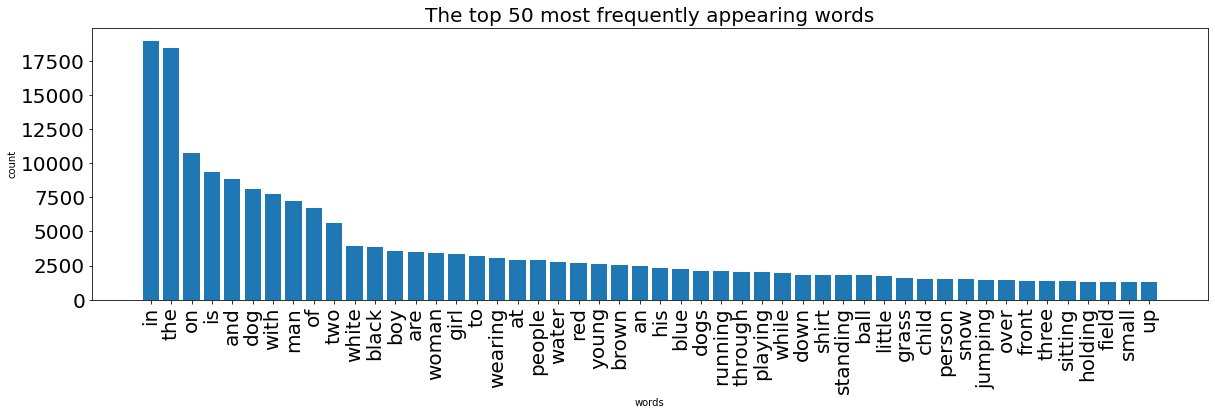

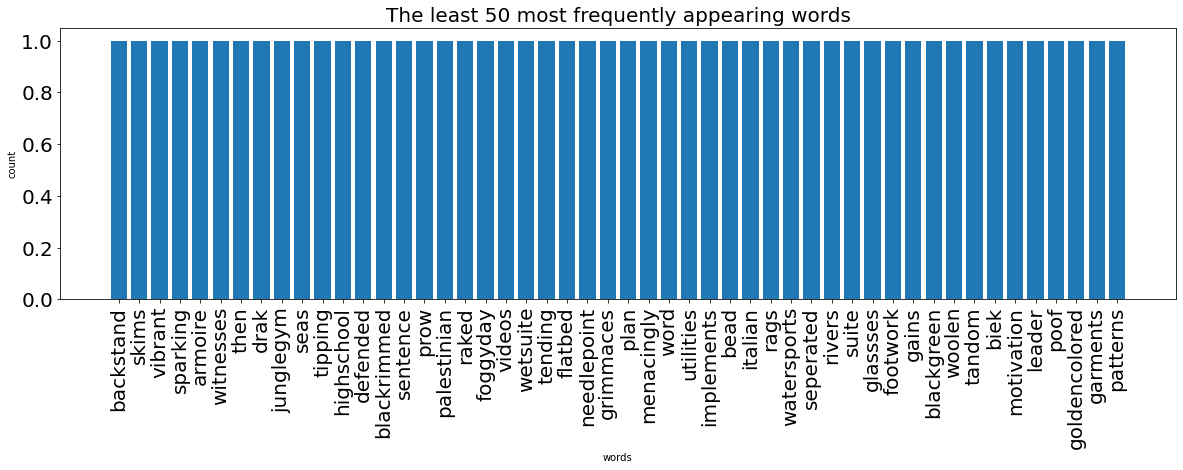

In [26]:
top=50 
plt.figure(figsize=(20,5))
plt.bar(dfword.iloc[:50,:].index, dfword.iloc[:50,:]['count'])
plt.yticks(fontsize=20)
plt.xticks(dfword.iloc[:50,:].index,dfword.iloc[:50,:]['word'],rotation=90,fontsize=20)
plt.xlabel('words')  
plt.ylabel('count') 
plt.title('The top 50 most frequently appearing words',fontsize=20)
plt.show()

plt.figure(figsize=(20,5))
plt.bar(dfword.iloc[-50:,:].index, dfword.iloc[-50:,:]['count'])
plt.yticks(fontsize=20)
plt.xticks(dfword.iloc[-50:,:].index,dfword.iloc[-50:,:]['word'],rotation=90,fontsize=20)
plt.xlabel('words')  
plt.ylabel('count') 
plt.title('The least 50 most frequently appearing words',fontsize=20)
plt.show()

In [27]:
#2.5 save_descriptions( descriptions, filename ) – This function will create a list of all the descriptions that have 
#been preprocessed and store them into a file. We will create a descriptions.txt file to store all the captions. 

In [28]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [29]:
save_descriptions(clean_descriptions, "descriptions_project1.txt")

In [30]:
model = InceptionV3( weights = 'imagenet' )
#model = Xception()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [31]:
model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# 3. Extracting the feature vector from all images 

In [32]:
def extract_features(directory):
        #model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            #image = image/127.5
            #image = image - 1.0
            feature = model_new.predict(image)
            features[img] = feature
        return features

In [33]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features_p1_inceptionV3.p","wb"))

C:\Users\smita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/8091 [00:00<?, ?it/s]

In [34]:
features = load(open("features_p1_inceptionV3.p","rb"))

In [35]:
features

{'1000268201_693b08cb0e.jpg': array([[0.09671375, 0.22957116, 0.7610036 , ..., 0.41570774, 0.45861265,
         0.40678307]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[0.7363114 , 0.56578374, 0.15076536, ..., 0.18146388, 0.49353322,
         1.1289792 ]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[0.2962748 , 0.11325707, 0.8681778 , ..., 1.021978  , 0.20522492,
         0.10968668]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[0.5377021 , 0.36562806, 0.38814232, ..., 0.93318254, 0.2800141 ,
         0.3130352 ]], dtype=float32),
 '1007129816_e794419615.jpg': array([[0.22740544, 0.18035555, 0.32690766, ..., 0.4513394 , 0.18046622,
         0.31133932]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[0.24815981, 0.587768  , 0.23926473, ..., 0.09665909, 1.0353777 ,
         0.69362825]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[0.57859546, 1.407111  , 0.8734836 , ..., 0.37787417, 0.91187495,
         1.28293   ]], dtype=float32),
 '1012

# 4. Loading dataset for Training the model

In [36]:
#load_photos( filename ) – This will load the text file in a string and will return the list of image names

In [37]:
filename = dataset_text + "\\" + "Flickr_8k.trainImages.txt"

In [38]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [39]:
train_imgs = load_photos(filename)

In [40]:
train_imgs

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [41]:
#load_clean_descriptions( filename, photos ) – This function will create a dictionary that contains captions for each 
#photo from the list of photos. We also append the <start> and <end> identifier for each caption. We need this so that 
#our LSTM model can identify the starting and ending of the caption.

In [42]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [43]:
train_descriptions = load_clean_descriptions("descriptions_project1.txt", train_imgs)

In [44]:
train_descriptions

{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<star

In [45]:
#load_features(photos) – This function will give us the dictionary for image names and their feature vector which we 
#have previously extracted from the Xception model.

In [46]:
def load_features(photos):
    #loading all features
    all_features = load(open("features_p1_inceptionV3.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [47]:
train_features = load_features(train_imgs)

In [48]:
train_features

{'2513260012_03d33305cf.jpg': array([[0.17074917, 0.18810773, 0.09738974, ..., 0.09092253, 1.3950456 ,
         0.41510606]], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([[0.13498664, 0.55184245, 0.43112582, ..., 0.7745252 , 0.40318134,
         0.93448913]], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([[0.16837691, 0.11373684, 0.08282221, ..., 0.32679585, 0.21684723,
         0.36970556]], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([[0.4769541 , 0.1054834 , 0.19762269, ..., 0.54806894, 0.93898696,
         0.6373059 ]], dtype=float32),
 '2644326817_8f45080b87.jpg': array([[0.25338092, 0.87567335, 0.04318532, ..., 0.        , 0.91859   ,
         1.1195916 ]], dtype=float32),
 '218342358_1755a9cce1.jpg': array([[0.6330309 , 0.16063268, 0.13320114, ..., 0.30914193, 0.31578937,
         0.82635564]], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([[0.11445624, 0.40066007, 1.1072878 , ..., 0.05293542, 0.84669244,
         0.8028247 ]], dtype=float32),
 '269934

# 5. Tokenizing the vocabulary

In [49]:
#Computers don’t understand English words, for computers, we will have to represent them with numbers. So, we will map 
#each word of the vocabulary with a unique index value. Keras library provides us with the tokenizer function that we 
#will use to create tokens from our vocabulary and save them to a “tokenizer.p” pickle file.

In [50]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [51]:
dict_to_list(descriptions)

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin',
 'black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other',
 'little girl covered in paint sits in front of painted rainbow with her hands in bowl',
 'little girl is sitting in front of large painted rainbow',
 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
 'there is girl with pigtails sitting in front of rainbow painting',
 'young girl with pigtails painting outside in the grass',
 'man lays on bench while his dog sits by him',
 'man

In [52]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer

In [53]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [54]:
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer_project1.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [55]:

#We calculate the maximum length of the descriptions. This is important for deciding the model structure parameters. 
#Max_length of description is 32.

In [56]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

# 6. Create Data generator

In [57]:
#Let us first see how the input and output of our model will look like. To make this task into a supervised learning task, 
#we have to provide input and output to the model for training. We have to train our model on 6000 images and each image 
#will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6000 images 
#is not possible to hold into memory so we will be using a generator method that will yield batches.
#The generator will yield the input and output sequence.

In [58]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [59]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [61]:
def data_generator(descriptions, features, word_index, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            #retrieve photo features
            feature = features[key][0]
            # walk through each description for the image
            for desc in desc_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                #seq = [ word_index[word] for word in desc.split(' ') if word in word_index ]
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                #input_image, input_sequence, output_word = np.array(X1), np.array(X2), np.array(y)
                #yield [[input_image, input_sequence], output_word]
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [62]:
#You can check the shape of the input and output for your model
batch_size = 3
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length, batch_size))
a.shape, b.shape, c.shape

((175, 2048), (175, 32), (175, 7577))

# 7. Defining the CNN-RNN model

In [ ]:
#To define the structure of the model, we will be using the Keras Model from Functional API. It will consist of three major 
#arts:

In [ ]:
# - Feature Extractor – The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the 
#dimensions to 256 nodes.
# - Sequence Processor – An embedding layer will handle the textual input, followed by the LSTM layer.
# - Decoder – By merging the output from the above two layers, we will process by the dense layer to make the final 
#prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [63]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [64]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1939712     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]      

# 8. Training the model

In [67]:
# train our model
epochs = 10
batch_size = 32
#steps = len(train_descriptions)//batch_size
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models_p1_200121")   with lr=0.0001
#os.mkdir("history_p1_200121")  
os.mkdir("models_p1_inceptionV3") #with lr=0.001 and dropout=0.2
os.mkdir("history_p1_inceptionV3")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, batch_size)
    history = model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models_p1_inceptionV3/model_" + str(i) + ".h5")
    dump(history.history, open("history_p1_inceptionV3/history_" + str(i) + ".p", 'wb'))

C:\Users\smita\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 24230s 4s/step - loss: 2.7063 - accuracy: 0.3834
Epoch 1/1
6000/6000 [==============================] - 24256s 4s/step - loss: 1.8536 - accuracy: 0.5041
Epoch 1/1
6000/6000 [==============================] - 25085s 4s/step - loss: 1.6216 - accuracy: 0.5497
Epoch 1/1
6000/6000 [==============================] - 26708s 4s/step - loss: 1.5020 - accuracy: 0.5742
Epoch 1/1
6000/6000 [==============================] - 26178s 4s/step - loss: 1.4206 - accuracy: 0.5918
Epoch 1/1
6000/6000 [==============================] - 27311s 5s/step - loss: 1.3612 - accuracy: 0.6048
Epoch 1/1
6000/6000 [==============================] - 28837s 5s/step - loss: 1.3123 - accuracy: 0.6162
Epoch 1/1
6000/6000 [==============================] - 26941s 4s/step - loss: 1.2761 - accuracy: 0.6244
Epoch 1/1
6000/6000 [==============================] - 29437s 5s/step - loss: 1.2420 - accuracy: 0.6327
Epoch 1/1
6000/6000 [==============================] - 30223s 5s

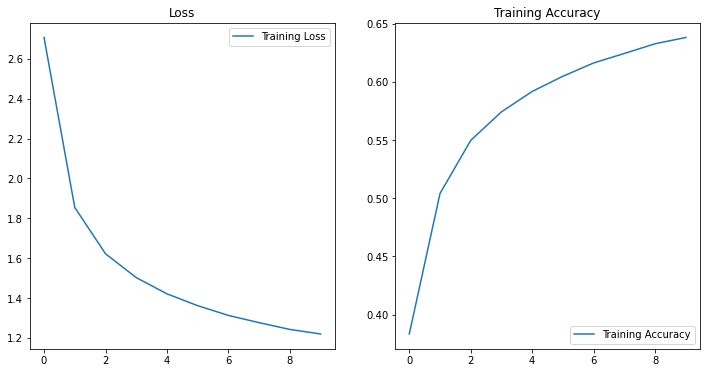

In [69]:
directory="C:\\Users\\smita\\Capstone Project\\history_p1_inceptionV3"
acc=[]
loss=[]
val_acc=[]
val_loss=[]
for i in os.listdir(directory):
    history=load(open(directory + "\\" + i, 'rb'))
    acc.append(history['accuracy'])
    loss.append(history['loss'])
#    val_acc.append(history['val_accuracy'])
#    val_loss.append(history['val_loss'])


#acc = history_xception.history['accuracy']
#val_acc = history.history['val_accuracy']

#loss = history_xception.history['loss']
#val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# 9. Testing the model

In [70]:
import time
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import copy

In [71]:
import tensorflow as tf
import keras

In [72]:
#from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.util import ngrams
from keras import optimizers

In [73]:
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

C:\Users\smita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

In [74]:
# Set these path according to project folder in you system
dataset_text = "C:\\Users\\smita\\Desktop\\Aegis School of Data Science\\Capstone Project Folder\\Flickr8k_text"
dataset_images = "C:\\Users\\smita\\Desktop\\Aegis School of Data Science\\Capstone Project Folder\\Flickr8k_Dataset\\Flicker8k_Dataset"

In [75]:
filename1 = dataset_text + "\\" + "Flickr_8k.testImages.txt"

In [76]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [77]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [78]:
test_imgs = load_photos(filename1)

In [79]:
len(test_imgs)

1000

In [80]:
def load_features(photos):
    #loading all features
    all_features = load(open("features_p1_inceptionV3.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [81]:
test_features = load_features(test_imgs)

In [82]:
test_features

{'3385593926_d3e9c21170.jpg': array([[0.18682978, 0.09099565, 0.1901068 , ..., 0.44177133, 0.89850235,
         0.28994998]], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([[0.7227087 , 0.54315895, 0.33045375, ..., 0.3114354 , 0.56474274,
         0.98434347]], dtype=float32),
 '311146855_0b65fdb169.jpg': array([[0.27834517, 0.24391016, 0.7286094 , ..., 0.13137977, 0.73584574,
         0.32812625]], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([[0.49762097, 0.18093637, 0.60404557, ..., 0.05764797, 0.1734423 ,
         0.18387602]], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([[0.01975943, 0.11064062, 0.24391975, ..., 0.39712596, 0.21736665,
         0.29104507]], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([[0.31991833, 0.3048353 , 0.297568  , ..., 0.66089827, 0.5691727 ,
         0.4131456 ]], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([[0.2825902 , 0.57520616, 0.5479773 , ..., 0.60234267, 0.7961688 ,
         0.11996198]], dtype=float32),
 '256085

In [83]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        #image = image/127.5
        #image = image - 1.0
        feature = model.predict(image)
        return feature

In [84]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
            return None

In [85]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
            
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [88]:
max_length = 32
tokenizer = load(open("tokenizer_project1.p","rb"))
model = load_model('models_p1_inceptionV3/model_9.h5')
model_1 = InceptionV3( weights = 'imagenet' )
model_2 = Model(model_1.input, model_1.layers[-2].output)
#xception_model = Xception(include_top=False, pooling="avg")

C:\Users\smita\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


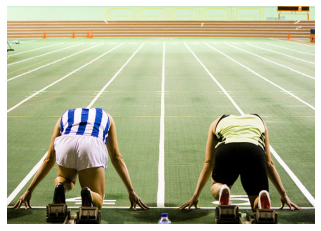

woman in red suit and capri and white shoes standing on tennis mat


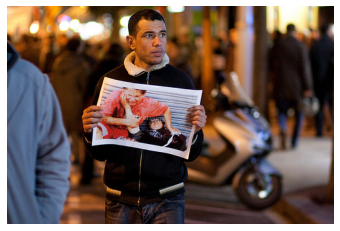

two men are sitting in chairs in front of railing while man is standing by him


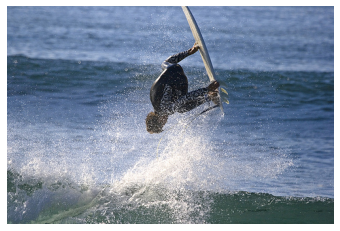

man in swimming trunks plays in the water beside the ocean


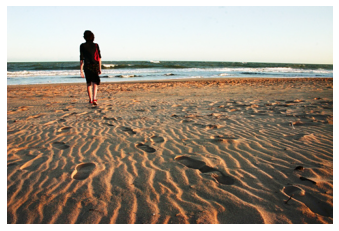

boy in swimsuit walking along beach


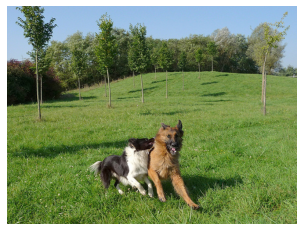

two dogs run through the grass


In [89]:
for i in range(5):
      
    rn = np.random.randint(1,len(test_imgs))
    img_name = test_imgs[rn]
    #img_name = list(test_features.keys())[rn]
    #photo = test_features[img_name].reshape((1,2048))
    photo = extract_features(dataset_images+'/'+img_name, model_2)
    i = plt.imread(dataset_images+'/'+img_name)
    plt.imshow(i)
    plt.axis('off')
    plt.show()
    
    caption = generate_desc(model, tokenizer, photo, max_length)
    print(caption)

# Bleu score

In [ ]:
""" Calculate BLEU score (Bilingual Evaluation Understudy) from Papineni, 
Kishore, Salim Roukos, Todd Ward, and Wei-Jing Zhu. 2002.
    BLEU: a method for automatic evaluation of machine translation."""

In [90]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [91]:
test_descriptions = load_clean_descriptions("descriptions_project1.txt", test_imgs)

In [92]:
test_descriptions

{'1056338697_4f7d7ce270.jpg': ['<start> blond woman in blue shirt appears to wait for ride <end>',
  '<start> blond woman is on the street hailing taxi <end>',
  '<start> woman is signaling is to traffic as seen from behind <end>',
  '<start> woman with blonde hair wearing blue tube top is waving on the side of the street <end>',
  '<start> the woman in the blue dress is holding out her arm at oncoming traffic <end>'],
 '106490881_5a2dd9b7bd.jpg': ['<start> boy in his blue swim shorts at the beach <end>',
  '<start> boy smiles for the camera at beach <end>',
  '<start> young boy in swimming trunks is walking with his arms outstretched on the beach <end>',
  '<start> children playing on the beach <end>',
  '<start> the boy is playing on the shore of an ocean <end>'],
 '1082379191_ec1e53f996.jpg': ['<start> lady and man with no shirt sit on dock <end>',
  '<start> man and woman are sitting on dock together <end>',
  '<start> man and woman sitting on dock <end>',
  '<start> man and woman 

In [93]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [94]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [95]:
tokenizer_test = create_tokenizer(test_descriptions)
dump(tokenizer_test, open('tokenizer_test_project1.p', 'wb'))
vocab_size = len(tokenizer_test.word_index) + 1
vocab_size

3177

In [96]:
test_desc = dict_to_list(test_descriptions)

In [97]:
test_desc

['<start> blond woman in blue shirt appears to wait for ride <end>',
 '<start> blond woman is on the street hailing taxi <end>',
 '<start> woman is signaling is to traffic as seen from behind <end>',
 '<start> woman with blonde hair wearing blue tube top is waving on the side of the street <end>',
 '<start> the woman in the blue dress is holding out her arm at oncoming traffic <end>',
 '<start> boy in his blue swim shorts at the beach <end>',
 '<start> boy smiles for the camera at beach <end>',
 '<start> young boy in swimming trunks is walking with his arms outstretched on the beach <end>',
 '<start> children playing on the beach <end>',
 '<start> the boy is playing on the shore of an ocean <end>',
 '<start> lady and man with no shirt sit on dock <end>',
 '<start> man and woman are sitting on dock together <end>',
 '<start> man and woman sitting on dock <end>',
 '<start> man and woman sitting on deck next to lake <end>',
 '<start> shirtless man and woman sitting on dock <end>',
 '<star

In [98]:
test_texts=tokenizer_test.texts_to_sequences(test_desc)

In [99]:
test_texts

[[2, 290, 18, 4, 27, 37, 774, 20, 1094, 75, 257, 1],
 [2, 290, 18, 6, 5, 3, 67, 1790, 1368, 1],
 [2, 18, 6, 1791, 6, 20, 624, 70, 775, 81, 116, 1],
 [2, 18, 8, 270, 124, 19, 27, 337, 146, 6, 1095, 5, 3, 221, 11, 3, 67, 1],
 [2, 3, 18, 4, 3, 27, 135, 6, 48, 79, 52, 338, 21, 1792, 624, 1],
 [2, 14, 4, 26, 27, 527, 132, 21, 3, 47, 1],
 [2, 14, 198, 75, 3, 78, 21, 47, 1],
 [2, 25, 14, 4, 142, 291, 6, 56, 8, 26, 251, 776, 5, 3, 47, 1],
 [2, 63, 29, 5, 3, 47, 1],
 [2, 3, 14, 6, 29, 5, 3, 227, 11, 28, 102, 1],
 [2, 208, 7, 10, 8, 489, 37, 171, 5, 354, 1],
 [2, 10, 7, 18, 16, 49, 5, 354, 128, 1],
 [2, 10, 7, 18, 49, 5, 354, 1],
 [2, 10, 7, 18, 49, 5, 921, 84, 20, 147, 1],
 [2, 324, 10, 7, 18, 49, 5, 354, 1],
 [2, 528, 11, 13, 9, 141, 6, 376, 82, 133, 5, 82, 777, 1],
 [2, 58, 13, 9, 355, 5, 3, 237, 1],
 [2, 13, 9, 113, 82, 133, 5, 3, 178, 1],
 [2, 13, 9, 6, 778, 82, 133, 5, 1096, 237, 8, 82, 529, 339, 1],
 [2, 13, 9, 1793, 82, 133, 5, 3, 573, 1369, 1],
 [2, 14, 8, 151, 1370, 1],
 [2, 32, 14, 4,

In [100]:
test_feat = dict_to_list(test_features)

In [101]:
test_feat

[array([0.18682978, 0.09099565, 0.1901068 , ..., 0.44177133, 0.89850235,
        0.28994998], dtype=float32),
 array([0.7227087 , 0.54315895, 0.33045375, ..., 0.3114354 , 0.56474274,
        0.98434347], dtype=float32),
 array([0.27834517, 0.24391016, 0.7286094 , ..., 0.13137977, 0.73584574,
        0.32812625], dtype=float32),
 array([0.49762097, 0.18093637, 0.60404557, ..., 0.05764797, 0.1734423 ,
        0.18387602], dtype=float32),
 array([0.01975943, 0.11064062, 0.24391975, ..., 0.39712596, 0.21736665,
        0.29104507], dtype=float32),
 array([0.31991833, 0.3048353 , 0.297568  , ..., 0.66089827, 0.5691727 ,
        0.4131456 ], dtype=float32),
 array([0.2825902 , 0.57520616, 0.5479773 , ..., 0.60234267, 0.7961688 ,
        0.11996198], dtype=float32),
 array([0.49653733, 0.19665669, 0.03556115, ..., 0.01777406, 0.57660156,
        0.41073915], dtype=float32),
 array([0.4022684 , 0.25952783, 0.09345718, ..., 0.71692944, 0.14516987,
        0.31371272], dtype=float32),
 array([0.

In [102]:
#from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer_test.word_index.items()])

In [103]:
tokenizer_test_dict={}
for key, desc in test_descriptions.items():
    tokenizer_test_dict[key]=tokenizer_test.texts_to_sequences(desc)

In [104]:
tokenizer_test_dict

{'1056338697_4f7d7ce270.jpg': [[2,
   290,
   18,
   4,
   27,
   37,
   774,
   20,
   1094,
   75,
   257,
   1],
  [2, 290, 18, 6, 5, 3, 67, 1790, 1368, 1],
  [2, 18, 6, 1791, 6, 20, 624, 70, 775, 81, 116, 1],
  [2, 18, 8, 270, 124, 19, 27, 337, 146, 6, 1095, 5, 3, 221, 11, 3, 67, 1],
  [2, 3, 18, 4, 3, 27, 135, 6, 48, 79, 52, 338, 21, 1792, 624, 1]],
 '106490881_5a2dd9b7bd.jpg': [[2, 14, 4, 26, 27, 527, 132, 21, 3, 47, 1],
  [2, 14, 198, 75, 3, 78, 21, 47, 1],
  [2, 25, 14, 4, 142, 291, 6, 56, 8, 26, 251, 776, 5, 3, 47, 1],
  [2, 63, 29, 5, 3, 47, 1],
  [2, 3, 14, 6, 29, 5, 3, 227, 11, 28, 102, 1]],
 '1082379191_ec1e53f996.jpg': [[2, 208, 7, 10, 8, 489, 37, 171, 5, 354, 1],
  [2, 10, 7, 18, 16, 49, 5, 354, 128, 1],
  [2, 10, 7, 18, 49, 5, 354, 1],
  [2, 10, 7, 18, 49, 5, 921, 84, 20, 147, 1],
  [2, 324, 10, 7, 18, 49, 5, 354, 1]],
 '1084040636_97d9633581.jpg': [[2,
   528,
   11,
   13,
   9,
   141,
   6,
   376,
   82,
   133,
   5,
   82,
   777,
   1],
  [2, 58, 13, 9, 355, 5, 

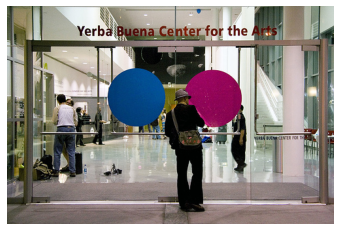

True captions:  [['man', 'is', 'standing', 'in', 'front', 'of', 'glass', 'doors', 'with', 'blue', 'spot', 'and', 'pink', 'spot'], ['man', 'is', 'standing', 'outside', 'the', 'glass', 'doors', 'of', 'an', 'art', 'center'], ['man', 'stands', 'at', 'the', 'entrance', 'of', 'yerba', 'buena', 'center', 'for', 'the', 'arts'], ['man', 'walking', 'through', 'glass', 'double', 'doors'], ['person', 'standing', 'at', 'glass', 'doors', 'with', 'big', 'blue', 'circle', 'and', 'big', 'pink', 'circle']]
Predict caption:  ['woman', 'in', 'knit', 'cap', 'walks', 'down', 'the', 'street', 'next', 'to', 'large', 'building']
sentence_bleus  [0.22619487599007523, 0.2672176720877289, 0.2672176720877289, 0, 0]
bleu_sent1  0.16666666666666669
bleu_sent2  0.2136319414145834
bleu_sent3  0.30117075419240696
bleu_sent4  0.31777715690119124
bleu_corp  0


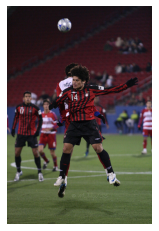

True captions:  [['man', 'in', 'red', 'striped', 'soccer', 'shirt', 'heads', 'ball'], ['man', 'in', 'red', 'and', 'black', 'is', 'hitting', 'soccer', 'ball', 'with', 'his', 'head'], ['soccer', 'ball', 'is', 'above', 'the', 'head', 'of', 'man', 'wearing', 'black', 'shorts', 'and', 'red', 'and', 'black', 'striped', 'shirt'], ['soccer', 'player', 'in', 'black', 'shorts', 'is', 'jumping', 'into', 'the', 'air'], ['the', 'person', 'in', 'the', 'red', 'and', 'black', 'uniform', 'has', 'ball', 'above', 'her', 'head']]
Predict caption:  ['two', 'opposing', 'footballers', 'play', 'inside', 'with', 'red', 'ball']
sentence_bleus  [0.5573216492398743, 0.3740946414850456, 0.18093584853794992, 0, 0.2983127821166947]
bleu_sent1  0.375
bleu_sent2  0.4270637959294343
bleu_sent3  0.5470399178767793
bleu_sent4  0.6167777926713333
bleu_corp  0


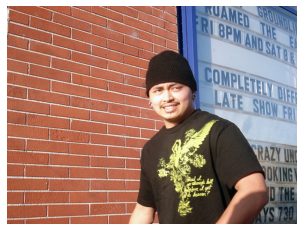

True captions:  [['man', 'in', 'black', 'hat', 'standing', 'in', 'front', 'of', 'brick', 'wall', 'and', 'sign'], ['man', 'in', 'knit', 'cap', 'stands', 'next', 'to', 'brick', 'wall'], ['man', 'standing', 'in', 'front', 'of', 'brick', 'building'], ['man', 'wearing', 'black', 'shirt', 'standing', 'in', 'front', 'of', 'red', 'brick', 'wall'], ['the', 'man', 'in', 'the', 'black', 'hat', 'has', 'his', 'back', 'to', 'theater', 'sign']]
Predict caption:  ['man', 'in', 'black', 'jacket', 'is', 'standing', 'next', 'to', 'man', 'in', 'black', 'jacket', 'in', 'front', 'of', 'building']
sentence_bleus  [0.28013207135950574, 0.24050850152000008, 0.19059483937121047, 0.19059483937121047, 0.2022427367662106]
bleu_sent1  0.625
bleu_sent2  0.45643546458763845
bleu_sent3  0.3484161012993529
bleu_sent4  0.32382906493121694
bleu_corp  0


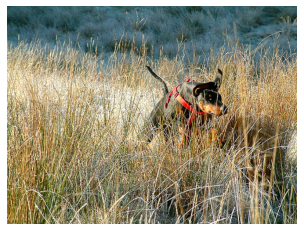

True captions:  [['brown', 'and', 'black', 'dog', 'jumping', 'through', 'field', 'of', 'long', 'blades', 'of', 'grass'], ['dog', 'runs', 'through', 'the', 'tall', 'grass'], ['dog', 'wearing', 'red', 'harness', 'runs', 'across', 'field'], ['black', 'and', 'brown', 'dog', 'with', 'red', 'harness', 'in', 'high', 'grass'], ['dog', 'running', 'through', 'the', 'weeds']]
Predict caption:  ['two', 'dogs', 'run', 'through', 'the', 'grass']
sentence_bleus  [0.3216173484044743, 0.6933956560212984, 0, 0.37743901957355774, 0.626553704075208]
bleu_sent1  0.5
bleu_sent2  0.316227766016838
bleu_sent3  0.5290511966038288
bleu_sent4  0.6933956560212984
bleu_corp  0


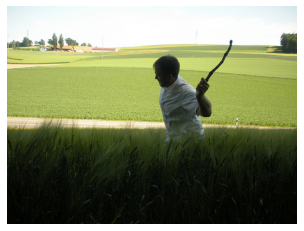

True captions:  [['man', 'in', 'white', 'shirt', 'swinging', 'stick'], ['man', 'in', 'white', 'shirt', 'walks', 'in', 'the', 'tall', 'grass', 'holding', 'stick'], ['man', 'is', 'walking', 'in', 'field', 'carrying', 'stick'], ['man', 'with', 'stick', 'in', 'his', 'left', 'hand', 'in', 'field'], ['man', 'near', 'golf', 'course', 'preparing', 'to', 'throw', 'stick']]
Predict caption:  ['little', 'boy', 'in', 'red', 'flowered', 'shorts', 'is', 'running', 'on', 'wet', 'grass']
sentence_bleus  [0.2999277941917045, 0.3566762668398468, 0.3566762668398468, 0.2999277941917045, 0]
bleu_sent1  0.2727272727272727
bleu_sent2  0.29007030294182284
bleu_sent3  0.37548448090727743
bleu_sent4  0.39472717569786586
bleu_corp  0


In [105]:
for i in range(5):
    #caption_trues, captions = [], []  
    rn = np.random.randint(1,len(test_imgs))
    img_name = test_imgs[rn]
    #img_name = list(test_features.keys())[rn]
    #photo = test_features[img_name].reshape((1,2048))
    photo = extract_features(dataset_images+'/'+img_name, model_2)
    im = plt.imread(dataset_images+'/'+img_name)
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    captions_true = []
    captions = []
    sentence_bleus=[]
    sentence_bleus1=[]
    sentence_bleus2=[]
    sentence_bleus3=[]
    sentence_bleus4=[]
    for k in range(5):
        #caption_trues, captions = [], []
        caption_true = [ index_word[i] for i in tokenizer_test_dict[img_name][k] ]
        caption_true = caption_true[1:-1]
        caption = generate_desc(model, tokenizer, photo, max_length)
        #caption = caption[1:-1]
        #bleu = float(sentence_bleu([caption_true],caption))
        #bleu = float(corpus_bleu([[caption_true]],[caption]))
        #caption_trues = '\n'.join(caption_true)
        captions_true.append(caption_true)
        caption = caption.split(' ') 
        #caption_trues = '\n'.join(caption_trues)
        captions.append(list(caption))
        """ To avoid harsh behaviour when no ngram overlaps are found a smoothing
    function can be used """
        smooth = SmoothingFunction()
        sentence_bleu0 = sentence_bleu([caption_true],caption,smoothing_function=smooth.method4)
        #sentence_bleu1 = sentence_bleu([caption_true],caption,smoothing_function=smooth.method2)
        #sentence_bleu2 = sentence_bleu([caption_true],caption,smoothing_function=smooth.method3)
        #sentence_bleu3 = sentence_bleu([caption_true],caption,smoothing_function=smooth.method4)
        #sentence_bleu4 = sentence_bleu([caption_true],caption,smoothing_function=smooth.method5)
        sentence_bleus.append(sentence_bleu0)
        #sentence_bleus1.append(sentence_bleu1)
        #sentence_bleus2.append(sentence_bleu2)
        #sentence_bleus3.append(sentence_bleu3)
        #sentence_bleus4.append(sentence_bleu4)
        
    bleu_sent1 = sentence_bleu(captions_true,caption,weights=(1.0,0,0,0), smoothing_function=smooth.method4)
    bleu_sent2 = sentence_bleu(captions_true,caption,weights=(0.5,0.5,0,0), smoothing_function=smooth.method4)
    bleu_sent3 = sentence_bleu(captions_true,caption,weights=(0.3,0.3,0.3,0), smoothing_function=smooth.method4)
    bleu_sent4 = sentence_bleu(captions_true,caption,weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method4)
    
    bleu_corp = corpus_bleu(captions_true,captions,weights=(0.25, 0.25, 0.25, 0.25))
        #bleus.append(bleu)
    
    print('True captions: ',captions_true)
    print('Predict caption: ',caption)
    print('sentence_bleus ',sentence_bleus)
    #print('sentence_bleus1 ',sentence_bleus1)
    #print('sentence_bleus2 ',sentence_bleus2)
    #print('sentence_bleus3 ',sentence_bleus3)
    #print('sentence_bleus4 ',sentence_bleus4)
    print('bleu_sent1 ',bleu_sent1)
    print('bleu_sent2 ',bleu_sent2)
    print('bleu_sent3 ',bleu_sent3)
    print('bleu_sent4 ',bleu_sent4)
    print('bleu_corp ',bleu_corp)
    #print('corpus_bleu ',corpus_bleu)

In [106]:
len(captions)

5

In [107]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    #print(actual)
    #print(predicted)
    print('BLEU-1: %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
    print('BLEU-2: %f' % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
    print('BLEU-3: %f' % corpus_bleu(actual,predicted,weights=(0.3,0.3,0.3,0)))
    print('BLEU-4: %f' % corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))

In [108]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.371121
BLEU-2: 0.208585
BLEU-3: 0.144412
BLEU-4: 0.062269


In [109]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.371121
BLEU-2: 0.208585
BLEU-3: 0.144412
BLEU-4: 0.062269


In [110]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.371121
BLEU-2: 0.208585
BLEU-3: 0.144412
BLEU-4: 0.062269
